## **Predicting gestational age at scan and birth for neonates from the developing Human Connectome Project**

ToC:
1. Create a DataSets from which sample (separate train and validation) batches at random using a DataLoader
2. augmentations so as to maximise the performance
3. Create a custom ResNet (with preactivation - [He 2016](https://arxiv.org/abs/1603.05027)) in order to perform regression. 
4. training loop and optimise
5. Visualise the outputs of network

## **The Data**

The cerebral cortex is a thin layer of tissue at the outer surface of the brain, where most cells responsible for higher-order cognitive processing are found. The creation and maturation of these cells develops rapidly during fetal and early neonatal development (in the weeks and months just before and after birth), which leads to cortical folding and dramatic changes in the observed intensities of T1 and T2-weighted Magnetic Resonance Imaging (MRI). MRI-derived metrics of cortical maturation will be used to **predict the gestational age at scan _and_ at birth of babies scanned as part of the Developing Human Connectome Project** (dHCP, Makropoulos et al 2018). 

<img src="https://drive.google.com/uc?id=1GLwUBYMQdOJPo3qLzzh518eoEcvlTOHj" alt="Drawing" style="width: 100px;"/>


In [15]:
!pip3 install SimpleITK
!pip3 install imageio
!pip3 install scikit-image
!pip3 install seaborn
!pip3 install nibabel
!pip3 install matplotlib
!pip3 install tqdm


import SimpleITK as sitk
import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm

import time
import seaborn as sns

# # initialize network weights as a gaussian
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)

save_path = Path('results')
os.makedirs(save_path, exist_ok=True)

You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


In [16]:
### cell/for testing file input/output/visualisation

data_dir = Path("data")
example_im = np.load(data_dir / "2D_projection_L_sub-0.npy")
meta_path = data_dir / "meta_2022_pma.pkl"
label_df = pd.read_pickle(meta_path)

print(label_df)

# plt.imshow(example_im[:, :, 0])
# print("subject meta data", label_df.iloc[0])
# print("example shape ", example_im.shape)

# NOTE PyTorch is going to expect your data batches to have shape BxCxHxW
# (Batch,Channels, Height, Width)!


     subj_id scan_pma
0          0     44.0
1          1    42.57
2          2    42.57
3          3     42.0
4          4    40.71
..       ...      ...
471      471    29.14
472      472    36.14
473      473    29.86
474      474    36.57
475      475     30.0

[476 rows x 2 columns]



# Custom DataSet and DataLoaders


In [17]:
import numpy as np
import pandas as pd

class GestationalAgeDataset(Dataset):
    """Gestational Age dataset."""

    def __init__(self, root_dir: Path, meta_dir: Path, transform=None, label_id="scan_pma"):
        """
        Args:
            root_dir (string): Directory with all the .npy files and the meta_2022_pma.pkl file.
            meta_dir (string): Path to the meta_2022_pma.pkl file.
            label_id (string/list): The column name of the label you want to predict.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.label_id = label_id
        self.meta_df = pd.read_pickle(meta_dir)

    def __len__(self):
        all_files = os.listdir(self.root_dir)
        all_files = [file for file in all_files if file.endswith(".npy")]
        return len(all_files)

    def __getitem__(self, idx):  # accept a list of indices

        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, list):
            subj_ids = idx
            images = [np.load(self.root_dir / f"2D_projection_L_sub-{i}.npy") for i in idx]
            images = [np.transpose(image, (2, 0, 1)) for image in images]
            images = np.concatenate(images, axis=0)
            labels = [self.meta_df[self.meta_df["subj_id"] == subj_id][self.label_id].values[0] for subj_id in subj_ids]
        elif isinstance(idx, int):
            subj_ids = idx
            images = np.load(self.root_dir / f"2D_projection_L_sub-{idx}.npy")
            images = np.transpose(images, (2, 0, 1))
            labels = self.meta_df[self.meta_df["subj_id"] == subj_ids][self.label_id].values[0]
        elif isinstance(idx, slice):
            stop_idx = idx.stop if idx.stop is not None else len(self)
            start_idx = idx.start if idx.start is not None else 0
            subj_ids = range(start_idx, stop_idx)
            images = [np.load(self.root_dir / f"2D_projection_L_sub-{i}.npy") for i in range(start_idx, stop_idx)]
            images = [np.transpose(image, (2, 0, 1)) for image in images]
            images = np.concatenate(images, axis=0)
            labels = [self.meta_df[self.meta_df["subj_id"] == subj_id][self.label_id].values[0] for subj_id in subj_ids]

        else:
            raise ValueError("idx must be of type int, list, or slice")
        
        if type(self.label_id) == list:
            labels = labels.astype(np.float64)

        sample = {"images": torch.tensor(images).float(), "labels": torch.tensor(labels).float()}

        if self.transform:
            sample = self.transform(sample)

        return sample


## Test Dataset and create separate dataloaders for train and validation.



dataset length 476
train batch shape torch.Size([8, 4, 240, 320])
train batch labels tensor([44.0000, 42.5700, 42.5700, 42.0000, 40.7100, 40.8600, 40.7100, 43.7100])


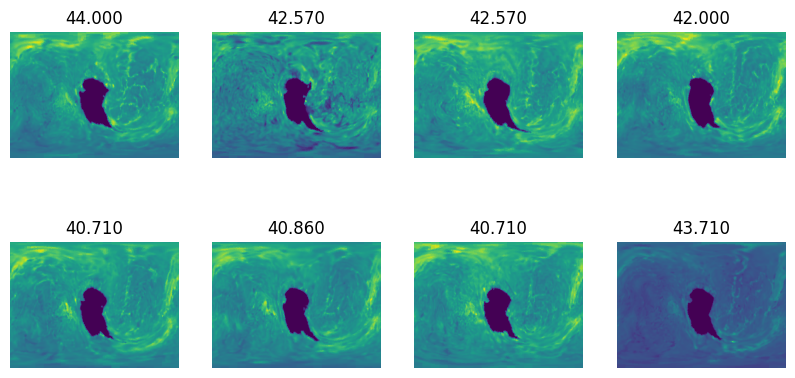

In [18]:
from torch.utils.data import Subset

# instantiate the dataset
dataset = GestationalAgeDataset(data_dir, meta_path)
print("dataset length", len(dataset))

# Create a Train Dataloader that samples from the first 425 subjects;
# NOTE I am using a batch size of 8 due to memory constraints; you can use a larger batch size if you have more memory
train_loader = DataLoader(Subset(dataset, range(425)), batch_size=8)
validation_loader = DataLoader(Subset(dataset, range(425, 476)), batch_size=51)

# return one batch from the train dataloader; print shape _and_ plot ( 2 mark)
train_batch = train_loader.__iter__().__next__()
print("train batch shape", train_batch["images"].shape)
print("train batch labels", train_batch["labels"])

# show subplot 2 * 4 round 3 decimal
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(train_batch["images"][i * 4 + j, 0, :, :].numpy())
        ax[i, j].set_title(f"{train_batch['labels'][i * 4 + j].numpy():.3f}")
        ax[i, j].axis("off")
plt.show()



# Create a pre-activation ResNet


## create a pre-activation residual block class

Modify the residual block `ResidualBlock` class from the `3.1.Architectures_2021.ipynb` notebook to implement preactivation residual blocks following the implementation in the 2016 paper [He 2016](https://arxiv.org/abs/1603.05027)

In [19]:
class ResidualBlockPreActivation(nn.Module):
    def __init__(self, channels1, channels2, res_stride=1):
        super().__init__()

        self.bn1 = nn.BatchNorm2d(channels1)
        self.conv1 = nn.Conv2d(channels1, channels2, kernel_size=3, stride=res_stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels2)
        self.conv2 = nn.Conv2d(channels2, channels2, kernel_size=3, stride=1, padding=1, bias=False)

        if res_stride != 1 or channels2 != channels1:  # if the image size changes or the number of channels changes
            self.shortcut = nn.Sequential(
                nn.Conv2d(channels1, channels2, kernel_size=1, stride=res_stride, bias=False), nn.BatchNorm2d(channels2)
            )

        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        # original forward pass: Conv2d > BatchNorm2d > ReLU > Conv2D >  BatchNorm2d > ADD > ReLU
        # pre-activation forward pass: BatchNorm2d > ReLU > Conv2d > BatchNorm2d > ReLU > Conv2d > ADD
        out = self.bn1(x)
        out = F.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv2(out)

        out += self.shortcut(x)

        return out


## Implement a ResNet class



In [20]:
class ResNet(nn.Module):
    def __init__(
        self,
        block,
        num_stride_conv1: int,
        num_features_conv1: int,
        num_blocks: list[int],
        num_strides_res: list[int],
        num_features_res: list[int],
        in_channels: int,
    ):
        super().__init__()
        input_size = np.array([240, 320])  # input image size
        assert len(num_blocks) == len(num_strides_res) == len(num_features_res), "length of lists must be equal"

        # first conv layer and batch norm
        self.in_planes = num_features_conv1
        self.conv1 = nn.Conv2d(in_channels, num_features_conv1, kernel_size=3, stride=num_stride_conv1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features_conv1)

        # add res layers iteratively for easier modification
        res_layers = []
        for i in range(len(num_blocks)):
            res_layers.append(
                self._make_layer(block, planes=num_features_res[i], num_blocks=num_blocks[i], stride=num_strides_res[i])
            )
        self.res_layers = nn.Sequential(*res_layers)

        # calculate the length of the linear layer with the given input size
        linear_len = input_size // num_stride_conv1 // 4  # 4 is the pooling factor
        linear_len = np.floor_divide(linear_len, np.prod(num_strides_res))
        self.linear_len = np.prod(linear_len) * num_features_res[-1]

        assert self.linear_len > 2048

        # the original resnet has a fully connected layer with 1000 output features
        # so it makes sense to have a single linear layer
        # but in this case we only have 1 output feature
        # so we can have 4 linear layers with 2048, 512, 128, 1 output features
        self.linear_1 = nn.Linear(self.linear_len, 2048)
        self.linear_2 = nn.Linear(2048, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 1)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []

        layers.append(block(channels1=self.in_planes, channels2=planes, res_stride=stride))

        for _ in np.arange(num_blocks - 1):
            layers.append(block(channels1=planes, channels2=planes))

        self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.res_layers(out)
        out = F.avg_pool2d(out, 4)  # size of the pooling window

        out = out.view(out.size(0), -1)
        out = self.linear_1(out)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out)
        out = F.relu(out)
        out = self.linear_4(out)

        return out


# Train for prediction of postmenstrual age at scan
Age at scan is a strong phenotype since the appearance of babies brains change dramatically over the first few weeks of life. This experiment can therefore be seen as a baseline from which to optimise performance of the network prior to training on birth age (which is more difficult)


## Initialise network, optimiser and loss function


In [21]:
!pip install torchsummary
import torchsummary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train batch shape torch.Size([32, 240, 320, 4])
net = ResNet(  # validation loss 0.877
    block=ResidualBlockPreActivation,
    in_channels=4,
    num_stride_conv1=1,
    num_features_conv1=64,
    # -------------------------
    num_blocks=[3, 4, 12, 3],
    num_strides_res=[1, 2, 2, 2],
    num_features_res=[64, 128, 256, 512],
)


net.to(device)

# the network has 2 convolutional layers per residual block
# the network has 3 + 4 + 16 + 3 = 26 residual blocks
# the network has 26 * 2 = 52 convolutional layers

torchsummary.summary(net, (4, 240, 320))


# CREATE LOSS OBJECT AND OPTIMISER
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

You should consider upgrading via the 'E:\Dropbox\~desktop\coursework-1~7MRI0010-Advanced-Machine-Learning\.venv_windows\Scripts\python.exe -m pip install --upgrade pip' command.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]           2,304
       BatchNorm2d-2         [-1, 64, 240, 320]             128
       BatchNorm2d-3         [-1, 64, 240, 320]             128
            Conv2d-4         [-1, 64, 240, 320]          36,864
       BatchNorm2d-5         [-1, 64, 240, 320]             128
            Conv2d-6         [-1, 64, 240, 320]          36,864
ResidualBlockPreActivation-7         [-1, 64, 240, 320]               0
       BatchNorm2d-8         [-1, 64, 240, 320]             128
            Conv2d-9         [-1, 64, 240, 320]          36,864
      BatchNorm2d-10         [-1, 64, 240, 320]             128
           Conv2d-11         [-1, 64, 240, 320]          36,864
ResidualBlockPreActivation-12         [-1, 64, 240, 320]               0
      BatchNorm2d-13         [-1, 64, 240, 320]             128
           Conv2d-14  


## Implement training and validation loops

Train network for 10 epochs.

Epoch 4; Train Loss: 1.176; Validation Loss: 0.988:  50%|█████     | 5/10 [04:43<04:43, 56.71s/it]


Model parameters saved as 0.988.pth


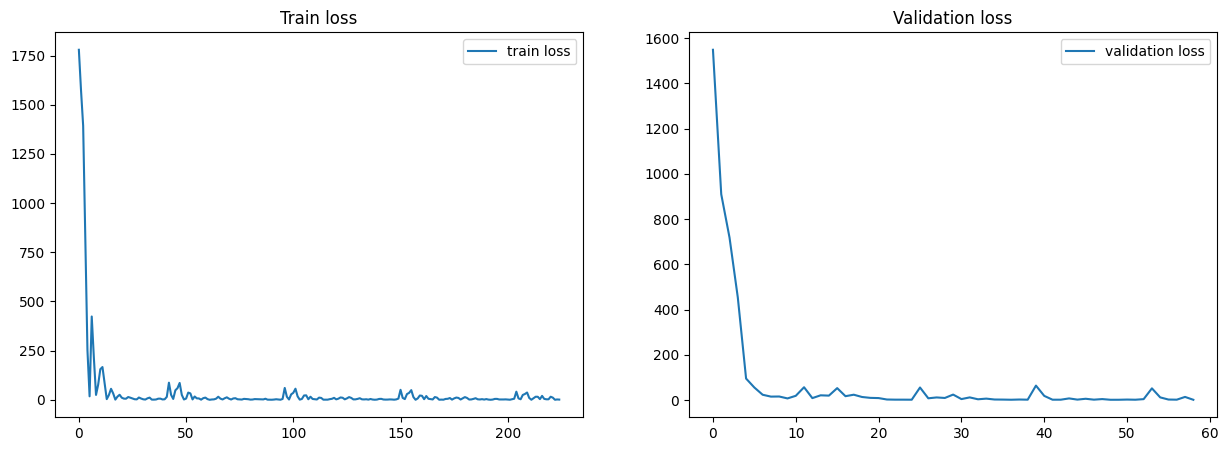

Validation loss below 1. Stopping training.


In [22]:
def train_step(model, optimizer, loss_fn, data, labels):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(model, validation_loader, val_loss_log, loss_fn):
    model.eval()
    with torch.no_grad():
        # there is only one batch
        for _, content in enumerate(validation_loader, 0):
            data, labels = content["images"], content["labels"]
            labels = labels.unsqueeze(1)
            data, labels = data.to(device), labels.to(device)

            output = model(data)
            loss = loss_fn(output, labels)
            loss_value = loss.item()
            val_loss_log.append(loss_value)
            return loss_value


def on_stop_training(net, progress_bar, train_loss_log, val_loss_log):
    # save the params
    progress_bar.close()
    net_layers = [layer for layer in net.modules() if isinstance(layer, nn.Conv2d)]
    net_layers = len(net_layers)
    os.makedirs("params", exist_ok=True)
    torch.save(net.state_dict(), Path("params") / f"params_{net_layers}_{val_loss_log[-1].__round__(3)}.pth")
    print(f"Model parameters saved as {val_loss_log[-1].__round__(3)}.pth")

    # plot the loss in two sub plots
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(train_loss_log, label="train loss")
    ax1.set_title("Train loss")
    ax1.legend()
    ax2.plot(val_loss_log, label="validation loss")
    ax2.set_title("Validation loss")
    ax2.legend()
    plt.show()


# training loop + validation loop
def train(
    net,
    train_loader,
    validation_loader,
    epochs,
    optimizer,
    loss_fn,
    early_stop_threshold,
    trained_params: Path = None,
):
    train_loss_log = []
    val_loss_log = []
    progress_bar = tqdm(range(epochs), colour="green", desc="Training")

    if trained_params is not None:
        net.load_state_dict(torch.load(trained_params))

    for epoch in range(epochs):
        progress_bar.update(1)

        for idx, content in enumerate(train_loader, 0):  # 0 is the starting index
            data, labels = content["images"], content["labels"]
            labels = labels.unsqueeze(1)
            data, labels = data.to(device), labels.to(device)

            # append statistics of the loss tensor
            ce_loss = train_step(net, optimizer, loss_fn, data, labels)
            train_loss_log.append(ce_loss)

            # validate every 4 batches
            if idx % 4 == 0:
                loss_value = validation_step(net, validation_loader, val_loss_log, loss_fn)
                progress_bar.set_description(
                    f"Epoch {epoch}; Train Loss: {ce_loss.__round__(3)}; Validation Loss: {loss_value.__round__(3)}"
                )

                # error_value < threshold: in this case it is the same since the loss function is MAE
                if loss_value < early_stop_threshold:
                    on_stop_training(net, progress_bar, train_loss_log, val_loss_log)
                    print(f"Validation loss below {early_stop_threshold}. Stopping training.")
                    return

    on_stop_training(net, progress_bar, train_loss_log, val_loss_log)


train(
    net=net,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stop_threshold=1,
)


# Design Custom Augmentations & Optimise

Now retrain but this time implement custom augmentations for training data set


## add a custom class for addition of Gaussian noise

ToC:
- Create a class which adds random gaussian noise to each datapoint of the image tensor
- set standard deviation as a tunable parameter
- test it on an example image and plot result

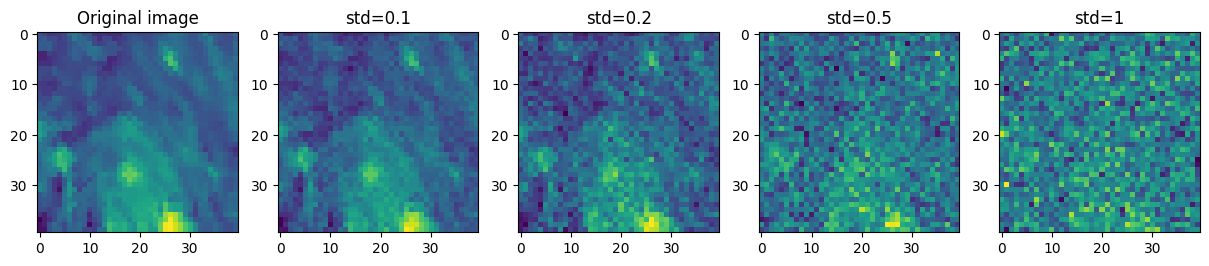

In [23]:
# a class which adds random gaussian noise to each datapoint of the image tensor
class GaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image = sample["images"]
        noise = torch.randn(image.shape) * self.std + self.mean
        image = image + noise
        sample["images"] = image
        return sample

    def __repr__(self):
        return self.__class__.__name__ + f"(mean={self.mean}, std={self.std})"

# create subplots
sample = dataset[0]

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# use the first subplot as the original image, zoom in on the image [80: 120] of the first channel
axs[0].imshow(sample["images"][0, 80:120, 80:120].numpy())
axs[0].set_title("Original image")

# for each of the other subplots, add gaussian noise and plot the image
for idx, std in enumerate([0.1, 0.2, 0.5, 1]):
    transform = GaussianNoise(std=std)
    axs[idx + 1].imshow(transform(sample)["images"][0, 80:120, 80:120].numpy())
    axs[idx + 1].set_title(f"std={std}")

plt.show()


## implement elastic augmentation

ToC:
-  Implementation of a class for elastic 2D augmentation
-  set the displacement magnitude and deformation smoothness as a tunable parameter
-  apply and plot for a test image


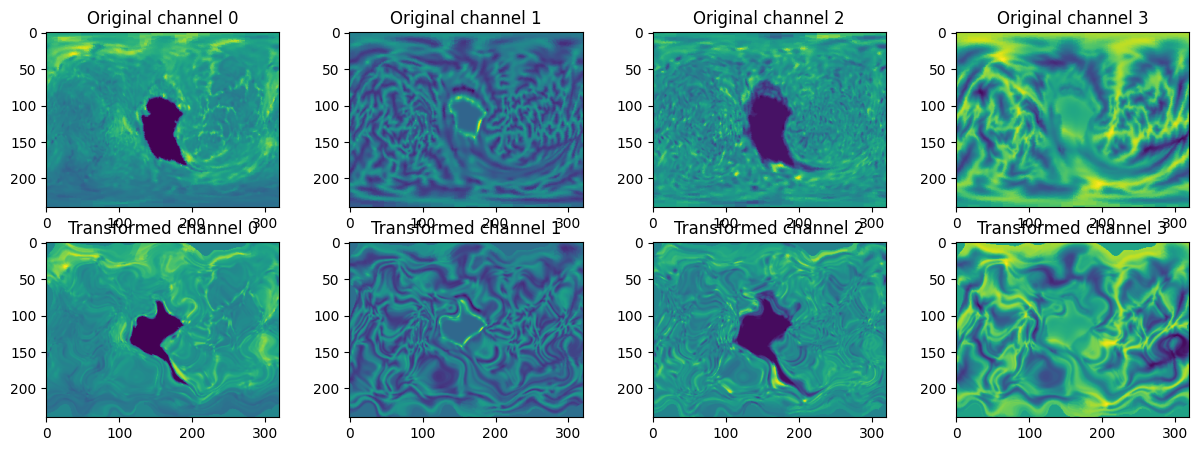

In [24]:
import numpy as np
from scipy.ndimage import map_coordinates, gaussian_filter


class ElasticTransform(object):
    def __init__(self, alpha, sigma, random_state=None):
        """
        Elastic deformation of 4D images.
        :param image: 4D numpy array of shape (4, height, width)
        :param alpha: scaling factor for the displacement
        :param sigma: smoothing factor for the displacement
        :param random_state: random state for the random number generator
        :return: 4D numpy array of shape (4, height, width)
        """
        self.alpha = alpha
        self.sigma = sigma
        self.random_state = random_state

    def __call__(self, sample):
        image = sample["images"]
        image = self.elastic_transform_4d(image)
        sample["images"] = image
        return sample

    def __repr__(self):
        return self.__class__.__name__ + f"(alpha={self.alpha}, sigma={self.sigma})"

    def elastic_transform_4d(self, image):
        assert image.shape[0] == 4

        if self.random_state is None:
            self.random_state = np.random.RandomState(None)

        shape = (image.shape[1], image.shape[2])

        dx = gaussian_filter((self.random_state.rand(*shape) * 2 - 1), self.sigma, mode="constant", cval=0) * self.alpha
        dy = gaussian_filter((self.random_state.rand(*shape) * 2 - 1), self.sigma, mode="constant", cval=0) * self.alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing="ij")
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        result = np.zeros_like(image)
        for i in range(4):
            result[i, :, :] = map_coordinates(image[i, :, :], indices, order=1).reshape(shape)

        result = torch.from_numpy(result)

        return result


# test the first channel of the image
sample = dataset[0]
image = sample["images"]
transform = ElasticTransform(alpha=500, sigma=10)
transformed = transform(sample)["images"]

# plot the channels of the original and transformed image
fig, (ax1, ax2) = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    ax1[i].imshow(image[i, :, :].numpy())
    ax2[i].imshow(transformed[i, :, :].numpy())
    ax1[i].set_title(f"Original channel {i}")
    ax2[i].set_title(f"Transformed channel {i}")

plt.show()


## Compose the transform and re-train



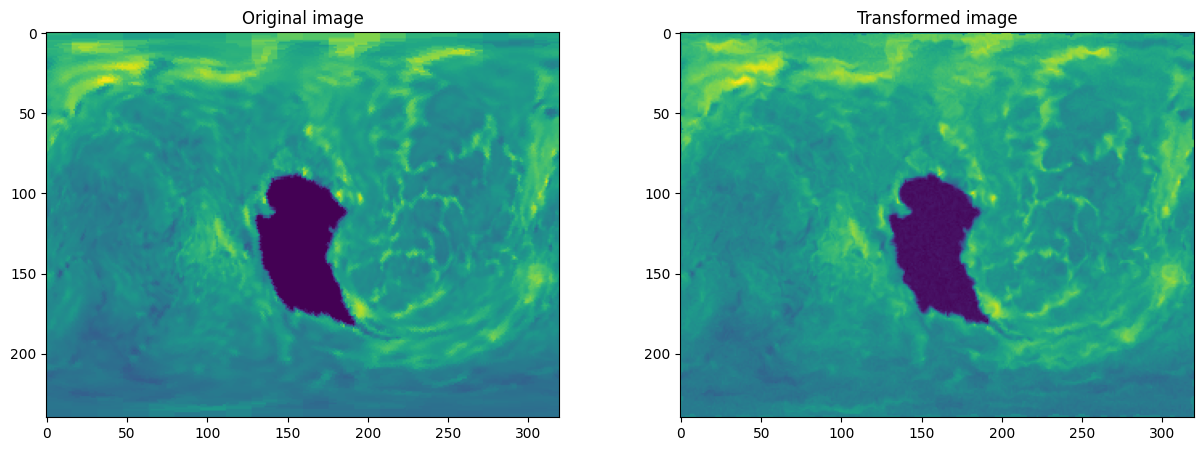

Epoch 0; Train Loss: 1.713; Validation Loss: 0.838:  10%|█         | 1/10 [00:34<05:10, 34.55s/it]


Model parameters saved as 0.838.pth


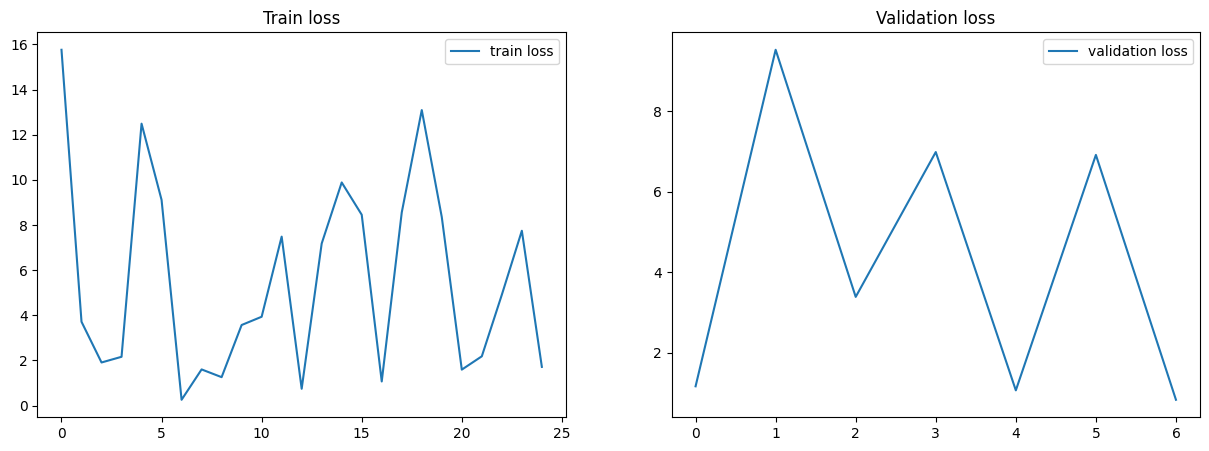

Validation loss below 1. Stopping training.


In [25]:
# create a transform which applies both the gaussian and elastic transform
transforms_pipeline = transforms.Compose([GaussianNoise(mean=0, std=0.1), ElasticTransform(alpha=10, sigma=2)])

# create a new dataset with the composed transform
dataset_transformed = GestationalAgeDataset(data_dir, meta_dir=meta_path, transform=transforms_pipeline)

# plot the first image of the original and transformed dataset
sample = dataset[0]
sample_transformed = dataset_transformed[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(sample["images"][0, :, :].numpy())
ax2.imshow(sample_transformed["images"][0, :, :].numpy())
ax1.set_title("Original image")
ax2.set_title("Transformed image")
plt.show()

train_loader_transformed = DataLoader(Subset(dataset_transformed, range(425)), batch_size=8)


train(
    net=net,
    train_loader=train_loader_transformed,
    validation_loader=validation_loader,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stop_threshold=1,
)


## Optimise
Try optimising the network further.


Epoch 13; Train Loss: 4.019; Validation Loss: 0.85:  47%|████▋     | 14/30 [18:15<20:51, 78.25s/it]


Model parameters saved as 0.85.pth


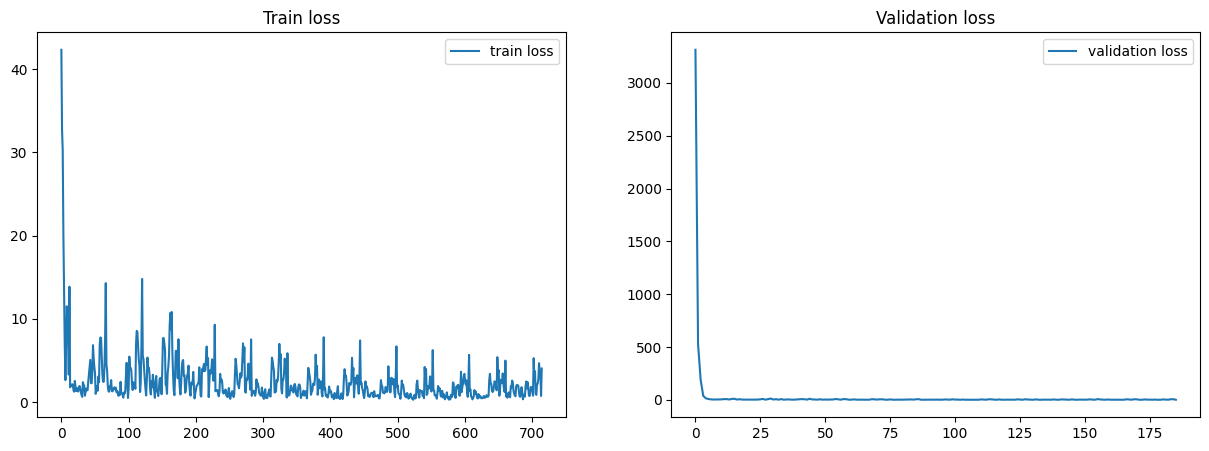

Validation loss below 0.9. Stopping training.


In [26]:
from torchvision import transforms


# # plot the variation of the label values in the entire dataset for checking outliers
# labels = [dataset[i]["labels"].item() for i in range(len(dataset))]
# plt.hist(labels, bins=len(set(labels)))
# plt.show()

# NOTE Strategies:
# - normalise the input data
# - use a different loss function (MAE loss) as the MSE is not very robust to outliers and the data has a lot of outliers
# - use a weight decay in the optimizer
# - amend model architecture to add more layers
# - initialize the weights of the model with kaiming initialization

net = ResNet(  # validation loss 0.877
    block=ResidualBlockPreActivation,
    in_channels=4,
    num_stride_conv1=1,
    num_features_conv1=64,
    # -------------------------
    num_blocks=[3, 4, 16, 3],
    num_strides_res=[1, 2, 2, 2],
    num_features_res=[64, 128, 256, 512],
)

# send the model to the GPU
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-6)  # has to be after the model is defined
loss_fn = nn.L1Loss(reduction="mean")

# init the weights of the model with Xavier initialization for the resnet
def init_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()


net.apply(init_weights)


def get_dataloader_stats(loader):
    """Returns the mean and standard deviation of the dataset."""
    mean = [0.0, 0.0, 0.0, 0.0]
    for images in loader:
        images = images["images"]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean_batch = images.mean(2).sum(0)
        mean[0] += mean_batch[0]
        mean[1] += mean_batch[1]
        mean[2] += mean_batch[2]
        mean[3] += mean_batch[3]
    mean = [m / len(loader.dataset) for m in mean]
    mean = torch.tensor(mean, dtype=torch.float).unsqueeze(1)

    var = [0.0, 0.0, 0.0, 0.0]
    for images in loader:
        images = images["images"]
        dimensions = (images.size()[2], images.size()[3])
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var_batch = ((images - mean) ** 2).sum([0, 2])
        var[0] += var_batch[0]
        var[1] += var_batch[1]
        var[2] += var_batch[2]
        var[3] += var_batch[3]
    var = [v / (len(loader.dataset) * dimensions[0] * dimensions[1]) for v in var]
    std = [torch.sqrt(v) for v in var]

    return tuple(mean), tuple(std)


class Normalize(object):
    def __init__(self, mean=(0, 0, 0, 0), std=(0.5, 0.5, 0.5, 0.5)):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image = sample["images"]
        image = transforms.functional.normalize(image, mean=self.mean, std=self.std)
        sample["images"] = image
        return sample


train_stats_mean, train_stats_std = get_dataloader_stats(train_loader)

transforms_pipeline = transforms.Compose(
    [
        GaussianNoise(mean=0, std=0.1),
        ElasticTransform(alpha=10, sigma=2),
        Normalize(mean=train_stats_mean, std=train_stats_std),
    ],
)
transforms_pipeline_valid = transforms.Compose([Normalize(mean=train_stats_mean, std=train_stats_std)])

# create a datasets with the composed transform
dataset_transformed = GestationalAgeDataset(data_dir, meta_dir=meta_path, transform=transforms_pipeline)
dataset_transformed_valid = GestationalAgeDataset(data_dir, meta_dir=meta_path, transform=transforms_pipeline_valid)

train_loader_transformed = DataLoader(Subset(dataset_transformed, range(425)), batch_size=8)
validation_loader_transformed = DataLoader(Subset(dataset_transformed_valid, range(425, 476)), batch_size=51)

# since we are using MAE loss, the error is the same as the loss so we can use the target error as the threshold
train(
    net=net,
    train_loader=train_loader_transformed,
    validation_loader=validation_loader_transformed,
    epochs=30,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stop_threshold=0.9,  
)

To optimize the network further, I implemented a several strategies including the following:

- Normalizing the input data: By normalizing the input data, we can ensure that the data has a zero mean and unit variance. This helps to reduce the impact of outliers in the pixel data and makes the training process more stable. 

- Using a different loss function: The Mean Squared Error (MSE) loss function is commonly used for regression problems, however, it may not be very robust to outliers in the data. In such cases, the Mean Absolute Error (MAE) loss function can be used as an alternative.

- Using weight decay in the optimizer: It adds a penalty term to the loss function that encourages the model to have smaller weights. This helps to reduce the complexity of the model and improve its generalization performance and therefore perform better on the validation set.

- Adding more layers to the model: Adding more layers to the model can increase its capacity and enable it to learn more complex representations of the input data. However, adding too many layers can also lead to overfitting. Therefore, without doing a systematic tunning I only add 2 additional residual blocks to ensure optimal performance.

- Initializing the weights of the model with kaiming initialization: It helps to ensure that the weights are initialized in a way that enables the network to learn effectively, while taking into account the non-linearity brought by the relu functions.

# Visualisation with occlusion



In [27]:
from math import ceil


def occlude_image(image, height_centre, width_centre, patch_size, occ_pixel):
    """
    Creates a copy of the image and occludes a patch
    input:
        image (Pytorch tensor): image to be occluded
        model: Pytorch network model
        height_centre=centre of patch on height dimension
        width_centre= centre of patch on width dimension
        patch_size: size of patch

    output:
        occluded_image: copy of image with patch occluded
    """

    # now make a new copy of image in memory;
    # the detach() method creates a copy of the tensor without copying it computation graph (i.e. sets requires_grad to false)
    occluded_image = image.detach().clone()

    height_start = int(height_centre - ceil(patch_size / 2))
    width_start = int(width_centre - ceil(patch_size / 2))

    height_start = 0 if height_start < 0 else height_start
    width_start = 0 if width_start < 0 else width_start

    height_end = height_start + patch_size
    width_end = width_start + patch_size

    if height_end >= occluded_image.shape[1]:
        height_end = occluded_image.shape[1] - 1
    if width_end >= occluded_image.shape[2]:
        width_end = occluded_image.shape[2] - 1

    occluded_image[:, height_start:height_end, width_start:width_end] = occ_pixel
    occluded_image = occluded_image.to(device)

    return occluded_image



def occlusion_all_channels(model, image, label, occ_size=50, occ_pixel=0.5, shrink_ratio=0.1):
    """
    Creates a heatmap of the occlusion sensitivity of the model on all channels of the image
    input:
        model: Pytorch network model
        image (Pytorch tensor): image to be occluded
        label (Pytorch tensor): label of image
        occ_size: size of patch
        occ_pixel: value of patch
        shrink_ratio: ratio between the heatmap size and the image size

    output:
        heatmap: heatmap of the occlusion sensitivity of the model
    """
    heatmap = torch.zeros((int(image.shape[1] * shrink_ratio), int(image.shape[2] * shrink_ratio)))

    for h in range(heatmap.shape[0]):
        for w in range(heatmap.shape[1]):
            occluded_image = image.clone()
            occluded_image = occlude_image(occluded_image, h//shrink_ratio, w//shrink_ratio, occ_size, occ_pixel)
            output_occluded = model(occluded_image.unsqueeze(0))
            heatmap[h, w] = abs(output_occluded.item() - label.item())

    return heatmap


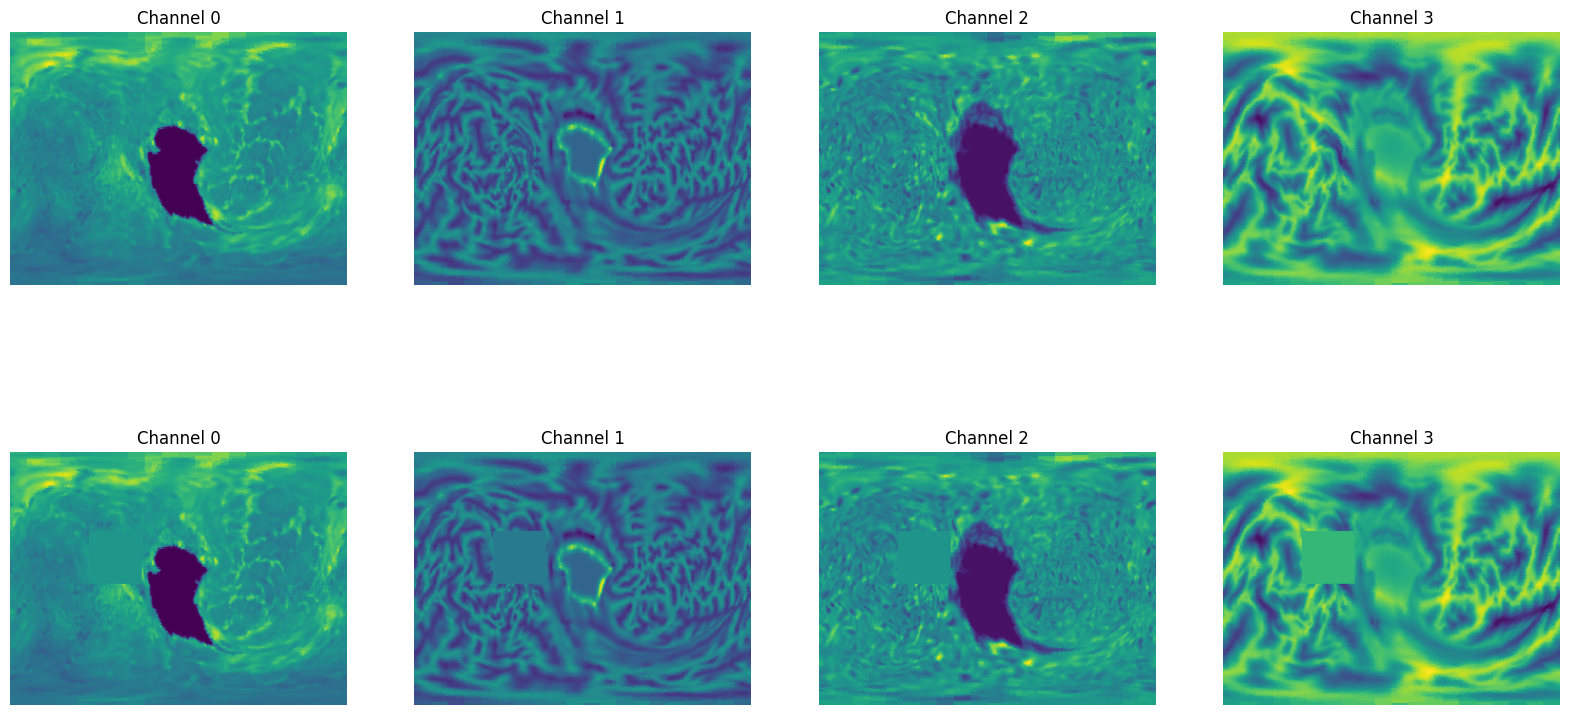

100%|██████████| 5/5 [02:38<00:00, 31.64s/it]


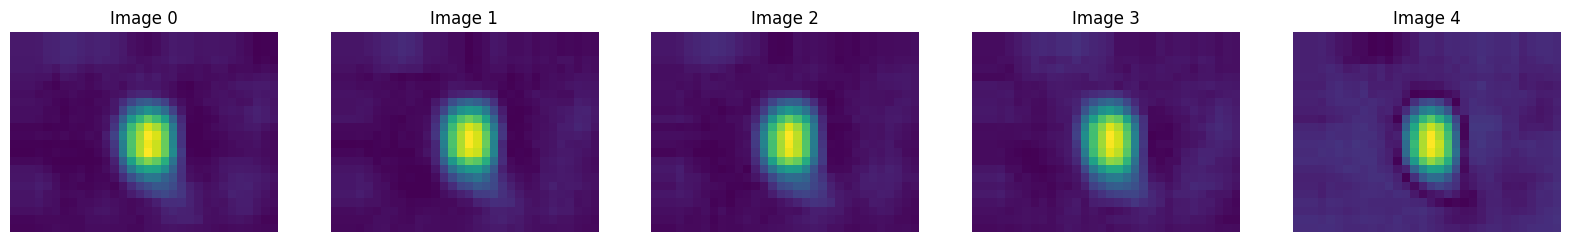

In [28]:
# get the first 5 images from the validation set
images = [dataset_transformed_valid[i]["images"] for i in range(5)]
labels = [dataset_transformed_valid[i]["labels"] for i in range(5)]


# test the occlusion function
sample = images[0]
sample_occluded = occlude_image(sample, 100, 100, 50, 0.5)

# plot the original and occluded images on all channels
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for channel in range(4):
    axs[0, channel].imshow(sample[channel, :, :])
    axs[0, channel].set_title(f"Channel {channel}")
    axs[0, channel].axis("off")
    axs[1, channel].imshow(sample_occluded[channel, :, :].cpu())
    axs[1, channel].set_title(f"Channel {channel}")
    axs[1, channel].axis("off")
plt.show()

# plot the occlusion heatmap for all channels
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in tqdm(range(5)):
    heatmap = occlusion_all_channels(net, images[i], labels[i], shrink_ratio=0.1)  # increase the shrink ratio to add resolution
    axs[i].imshow(heatmap)
    axs[i].set_title(f"Image {i}")
    axs[i].axis("off")
plt.show()


# Birth Age Prediction

## Create a new pipeline for Gestational Age predictions and train a network

subj_id         0
scan_ga     40.14
scan_pma     44.0
Name: 0, dtype: object


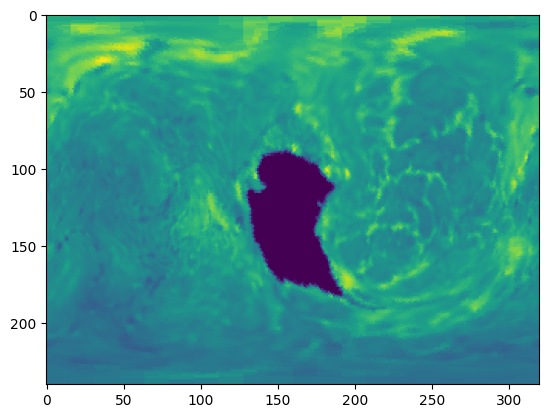

In [29]:
dir_name = Path("data_ga")

example_im = np.load(dir_name / "2D_projection_L_sub-0.npy")
meta_path = dir_name / "meta_2022_ga_age_label.pkl"
label_df = pd.read_pickle(meta_path)
plt.imshow(example_im[:, :, 0])
print(label_df.iloc[0])


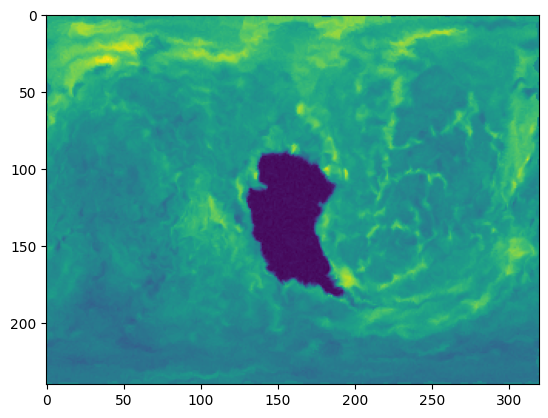

In [30]:
dataset_ga_train = GestationalAgeDataset(
    root_dir=dir_name,
    meta_dir=meta_path,
    transform=transforms_pipeline,
    label_id="scan_ga",
)
dataset_ga_val = GestationalAgeDataset(
    root_dir=dir_name,
    meta_dir=meta_path,
    transform=transforms_pipeline_valid,
    label_id="scan_ga",
)

# Create dataloaders for training and validation - with the first 411 subjects for training and the 51 remaining for valiation.
# NOTE I am using a batch size of 8 due to memory constraints; you can use a larger batch size if you have more memory
train_loader_ga = DataLoader(Subset(dataset_ga_train, range(411)), batch_size=8)
validation_loader_ga = DataLoader(Subset(dataset_ga_val, range(411, 462)), batch_size=51)

# plot the first image in the training set
plt.imshow(dataset_ga_train[0]["images"][0])
plt.show()


Epoch 9; Train Loss: 1.639; Validation Loss: 3.946: 100%|██████████| 10/10 [13:05<00:00, 78.52s/it]


Model parameters saved as 3.946.pth


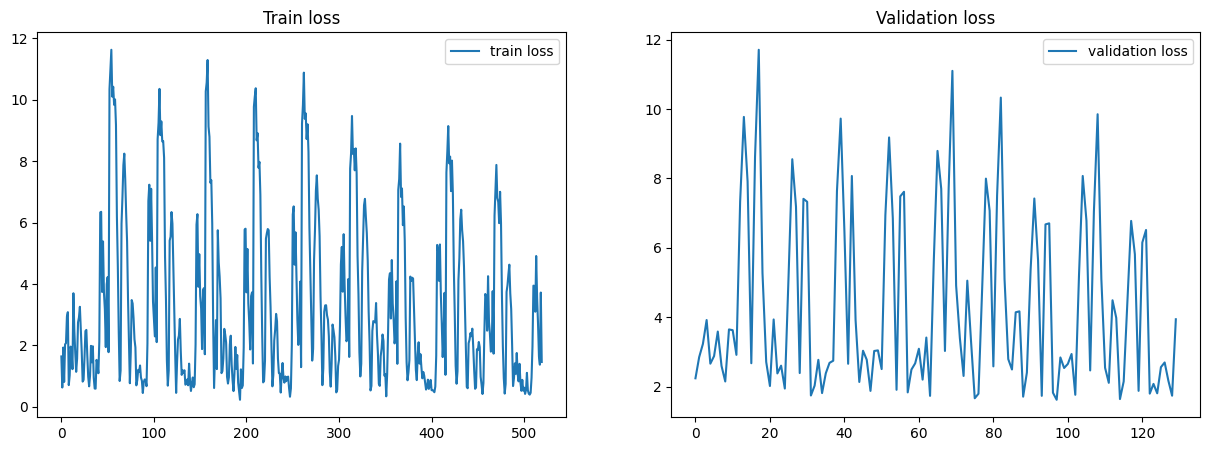

In [31]:
# train the model
train(
    net=net,
    train_loader=train_loader_ga,
    validation_loader=validation_loader_ga,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stop_threshold=1
)

# the difference: the model now has a much worse validation loss as compared to when the pma was used as a label


## Create a new Dataset for Gestational Age predictions with confounds

C:\Users\Don Yin\AppData\Local\Temp\ipykernel_30536\697689527.py:20: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  class_counts = torch.bincount(torch.tensor(labels, dtype=torch.int64))
C:\Users\Don Yin\AppData\Local\Temp\ipykernel_30536\697689527.py:24: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  sample_weights = weights[torch.tensor(labels, dtype=torch.int64)]


tensor([40.1400, 44.0000])
tensor([41.1400, 42.5700])
tensor([37.7100, 42.5700])
tensor([41.8600, 42.0000])
tensor([40.0000, 40.7100])


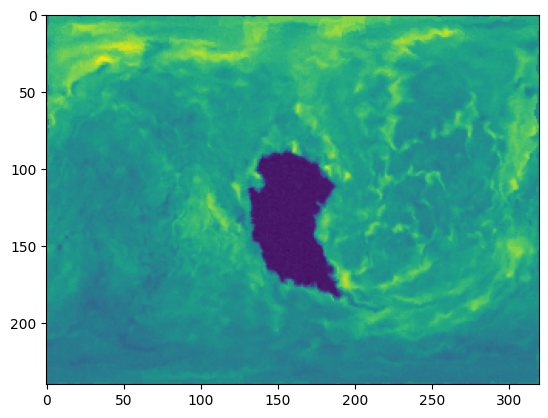

In [32]:
from torch.utils.data import WeightedRandomSampler

dataset_ga_train = GestationalAgeDataset(
    root_dir=dir_name,
    meta_dir=meta_path,
    transform=transforms_pipeline,
    label_id=["scan_ga", "scan_pma"],
)
dataset_ga_val = GestationalAgeDataset(
    root_dir=dir_name,
    meta_dir=meta_path,
    transform=transforms_pipeline_valid,
    label_id=["scan_ga", "scan_pma"],
)

# address the problem of class imbalance by using a weighted random sampler
# Assign a weight to each sample based on its label
labels = [i['labels'][0].item() for i in Subset(dataset_ga_train, range(411))]
class_counts = torch.bincount(torch.tensor(labels, dtype=torch.int64))
weights = 1.0 / class_counts.float()
weights[weights == float("inf")] = 1.0
# extrapolate sample weights to the full dataset
sample_weights = weights[torch.tensor(labels, dtype=torch.int64)]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create dataloaders for training and validation - with the first 411 subjects for training and the 51 remaining for valiation.
train_loader_ga = DataLoader(Subset(dataset_ga_train, range(411)), batch_size=8, sampler=sampler)
validation_loader_ga = DataLoader(Subset(dataset_ga_val, range(411, 462)), batch_size=51)


# print the labels for the first 5 images
[print(dataset_ga_train[i]["labels"]) for i in range(5)]

# plot the first image in the training set
plt.imshow(dataset_ga_train[0]["images"][0])
plt.show()


## Edit ResNet to deconfound Gestational Age predictions with age at scan

Prediction of gestational age at birth is a more difficult task than scan age prediction. Indeed, this task is highly correlated to the PMA at scan. Therefore, to improve GA predictions [Fawaz et al 2021](https://www.biorxiv.org/content/10.1101/2021.12.01.470730v1) incorporated scan age as a confound into the model before the last linear layer (see Figure 4); while [Dahan et al 2021](https://openreview.net/pdf?id=mpp843Bsf-) added that information in the first stages of the architecture (Appendix B.2).



In [33]:
class ResNetModified(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_1 = nn.Linear(self.linear_len + 1, 2048)
        self.linear_2 = nn.Linear(2048 + 1, 512)
        self.linear_3 = nn.Linear(512 + 1, 128)
        self.linear_4 = nn.Linear(128 + 1, 1)

    def forward(self, x, scan_pma):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.res_layers(out)
        out = F.avg_pool2d(out, 4)  # size of the pooling window

        out = out.view(out.size(0), -1)

        # add the scan_pma to the output of the last layer
        # here I concatenate the scan_pma to the output of each linear layer
        # so that the model can learn to deconfound by itself
        out = torch.cat((out, scan_pma), dim=1)
        out = self.linear_1(out)
        out = F.relu(out)

        out = torch.cat((out, scan_pma), dim=1)
        out = self.linear_2(out)
        out = F.relu(out)

        out = torch.cat((out, scan_pma), dim=1)
        out = self.linear_3(out)
        out = F.relu(out)

        out = torch.cat((out, scan_pma), dim=1)
        out = self.linear_4(out)

        return out

# redefine the model with the same parameters as before
net = ResNetModified(
    block=ResidualBlockPreActivation,
    in_channels=4,
    num_stride_conv1=1,
    num_features_conv1=64,
    # -------------------------
    num_blocks=[3, 4, 16, 3],
    num_strides_res=[1, 2, 2, 2],
    num_features_res=[64, 128, 256, 512],
)

# send the model to the GPU
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)  # has to be after the model is defined
loss_fn = nn.L1Loss(reduction="mean")
net.apply(init_weights)

# the train / validation steps has to be adapted to include the scan_pma
def train_step(model, optimizer, loss_fn, data, labels, scan_pma):
    model.train()
    optimizer.zero_grad()
    output = model(data, scan_pma)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(model, validation_loader, val_loss_log, loss_fn):
    model.eval()
    with torch.no_grad():
        # there is only one batch
        for _, content in enumerate(validation_loader, 0):
            data, labels = content["images"], content["labels"]
            labels, scan_pma = labels.split(1, dim=1)
            data, labels, scan_pma = data.to(device), labels.to(device), scan_pma.to(device)

            output = model(data, scan_pma)
            loss = loss_fn(output, labels)
            loss_value = loss.item()
            val_loss_log.append(loss_value)
            return loss_value

# rewrite the train function to include the scan_pma as an input
def train(
    net, train_loader, validation_loader, epochs, optimizer, loss_fn, early_stop_threshold, trained_params: Path = None,
):
    train_loss_log = []
    val_loss_log = []
    progress_bar = tqdm(range(epochs), colour="green", desc="Training")

    if trained_params is not None:
        net.load_state_dict(torch.load(trained_params))

    for epoch in range(epochs):
        progress_bar.update(1)

        for idx, content in enumerate(train_loader, 0):  # 0 is the starting index
            data, labels = content["images"], content["labels"]
            labels, scan_pma = labels.split(1, dim=1)
            data, labels, scan_pma = data.to(device), labels.to(device), scan_pma.to(device)

            # print statistics of loss tensor
            ce_loss = train_step(net, optimizer, loss_fn, data, labels, scan_pma)
            train_loss_log.append(ce_loss)

            if idx % 4 == 0:
                loss_value = validation_step(net, validation_loader, val_loss_log, loss_fn)
                progress_bar.set_description(
                    f"Epoch {epoch}; Train Loss: {ce_loss.__round__(3)}; Validation Loss: {loss_value.__round__(3)}"
                )

                # error_value < early_stop_threshold: in this case it is the same since the loss function is MAE
                if loss_value < early_stop_threshold:
                    on_stop_training(net, progress_bar, train_loss_log, val_loss_log)
                    print(f"Validation error below {early_stop_threshold}. Stopping training.")
                    return

    on_stop_training(net, progress_bar, train_loss_log, val_loss_log)


## Train and optimise


Epoch 6; Train Loss: 0.688; Validation Loss: 1.499:   7%|▋         | 7/100 [08:14<1:49:35, 70.70s/it]


Model parameters saved as 1.499.pth


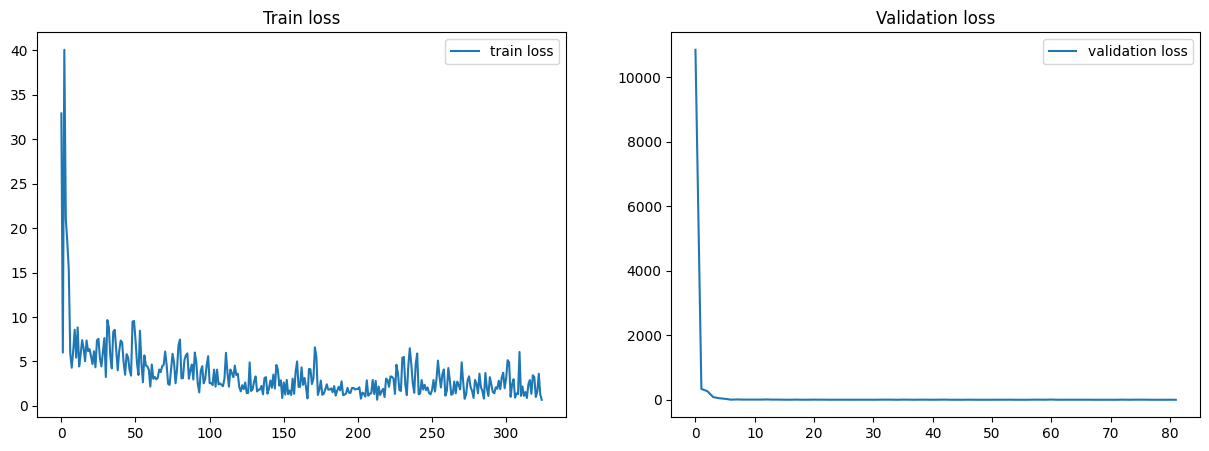

Validation error below 1.5. Stopping training.


In [34]:
train(
    net=net,
    train_loader=train_loader_ga,
    validation_loader=validation_loader_ga,
    epochs=100,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stop_threshold=1.5,
)
